In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit
import optax

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import spatial_maps as sm
import scipy

import astropy
import astropy.convolution
plt.style.use("bioAI.mplstyle")

In [2]:
# initialize RNG
key = jax.random.PRNGKey(0)

In [3]:
class Trapezoid(object):
    def __init__(self, x_size = 2, y_min = 0.1, y_max = 1):
        self.x_size = x_size
        self.y_min = y_min
        self.y_max = y_max

    def inside(self, x):
        y_val = (self.y_min-self.y_max)/2*x[:,0]/self.x_size + (self.y_max+self.y_min)/2
        inside = (jnp.abs(x[:,1]) < y_val )*(jnp.abs(x[:,0]) < self.x_size)
        return inside 

    def sample(self, n, key, n_trials = 100):
        pos = []
        n_accept = 0
        for i in range(n_trials):
            key, subkey = jax.random.split(key)
            r = jax.random.uniform(subkey, (n, 2), minval=-self.x_size, maxval = self.x_size)
            key, subkey = jax.random.split(key)
            accepted = self.inside(r)
            pos.append(r[accepted])
            n_accept+=accepted.sum()
            if n_accept >= n:
                break
        return jnp.concatenate(pos, axis=0)[:n]
    
class Rectangle(object):
    def __init__(self, x_size = 2, y_size = 2):
        self.x_size = x_size
        self.y_size = y_size

    def sample(self, n, key):
        x = jax.random.uniform(key, (n, 2), minval=jnp.array([-self.x_size, -self.y_size])[None], maxval=jnp.array([self.x_size, self.y_size])[None])
        return x


In [4]:
# number of training samples
train_samples = 100_000

(-2.1988402605056763,
 2.194517731666565,
 -1.0251070261001587,
 1.072632908821106)

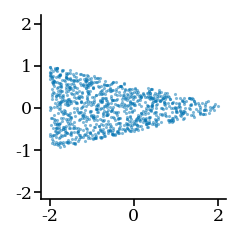

In [5]:
# initialize dataset
trapezoid_arena = Trapezoid()
key, subkey = jax.random.split(key)
trapezoid_dataset = trapezoid_arena.sample(train_samples, subkey)
plt.plot(*trapezoid_dataset[:1000].T, "o", alpha = 0.5)
plt.axis("equal")

(-2.0, 2.0, -2.0, 2.0)

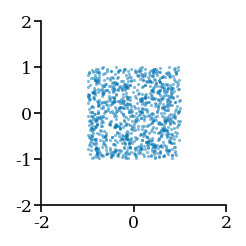

In [6]:
# Square arena, flat metric, same area as trapz
trapezoid_area = 2*trapezoid_arena.x_size*2*trapezoid_arena.y_max/2
square_side_length = np.sqrt(trapezoid_area) # same area!
square_arena = Rectangle(square_side_length/2, square_side_length/2)
key, subkey = jax.random.split(key)
square_dataset = square_arena.sample(train_samples, subkey)
plt.plot(*square_dataset[:1000].T, "o", alpha = 0.5)
plt.axis([-2, 2, -2, 2])


In [7]:
def representation_func(r, mu, sigma):
    return jnp.sum(jnp.exp(-jnp.sum((r[None, None] - mu)**2 / (2 * sigma**2), axis=-1)), axis=-1)

representation_jacobian = jax.jacfwd(representation_func, argnums=0)

# and vmap
batch_representation_func = jax.vmap(representation_func, in_axes= (0, None, None))
representation_jacobian = jax.vmap(representation_jacobian, in_axes=(0, None, None))

In [8]:
# set up target metrics
def flat_metric(x):
    return jnp.eye(2)

def distorted_metric(x):
    # d = ax+ b
    # e = -ax0 + b
    # c = ax0 + b
    # b = (e+c)/2
    # a = (b-e)/x0 = (c-e)/(2x0)
    alpha = 0.1
    beta = 5
    x0 = 2
    factor = (alpha - beta)/(2*x0)*x[...,0] + (beta+alpha)/2
    return factor*jnp.eye(2)

flat_metric = jax.vmap(flat_metric)
distorted_metric = jax.vmap(distorted_metric)

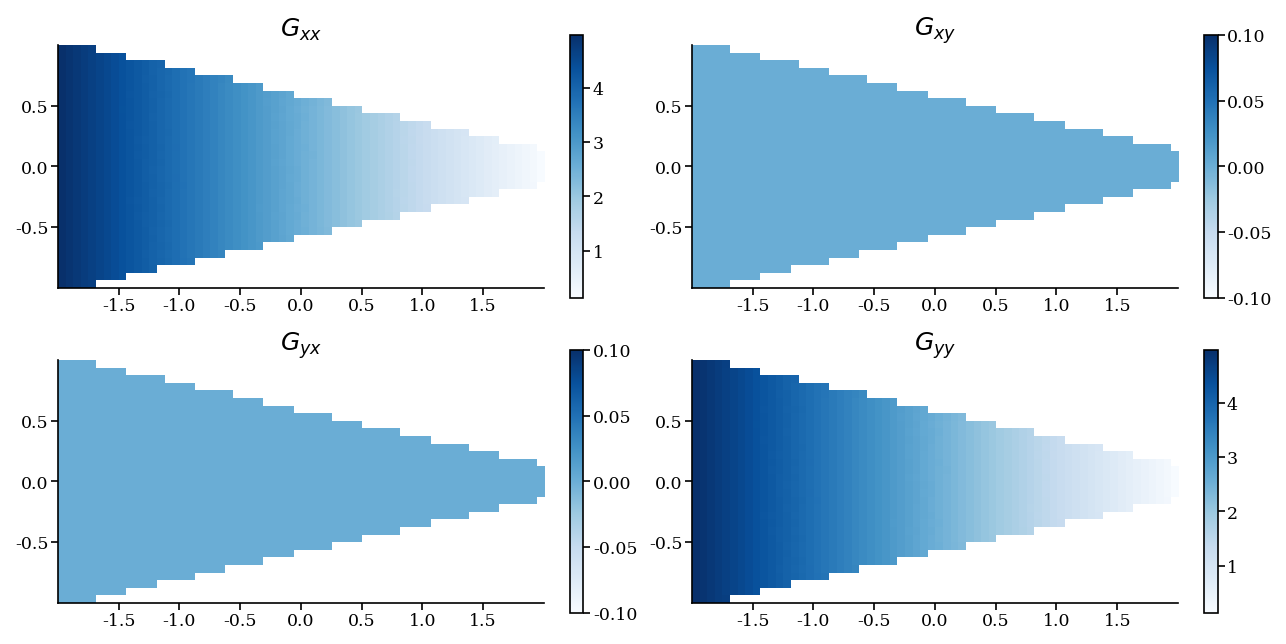

In [9]:
rr = trapezoid_dataset # visualize metric
m = distorted_metric(rr)
fig, ax = plt.subplots(2, 2, figsize = (10, 5))
count = 0
titles = ["$G_{xx}$", "$G_{xy}$", "$G_{yx}$", "$G_{yy}$"]
for i in range(2):
    for j in range(2):
        mij = scipy.stats.binned_statistic_2d(rr[:,0], rr[:,1], m[:,i,j], bins = [64, 32])[0]
        im = ax[i,j].imshow(mij.T, extent = [np.amin(rr[:,0]), np.amax(rr[:,0]), np.amin(rr[:,1]), np.amax(rr[:,1])])
        ax[i,j].set_title(titles[count])
        plt.colorbar(im, ax = ax[i,j], fraction = 0.03,)
        count += 1


In [10]:
class Geometer(object):
    def __init__(self, arena, target_metric, key, nc = 256, nf = 30, sigma = 0.2):
        self.arena = arena
        self.target_metric = target_metric
        self.nc = nc
        self.nf = nf 
        self.sigma = sigma

        # initialize parameters
        key, subkey = jax.random.split(key)
        centers = arena.sample(nc*nf, subkey).reshape(nc, nf, 2)
        key, subkey = jax.random.split(key)
        scale = 50.0
        self.params = {"scale": scale, "centers":centers}

    # @jit
    def train(self, key, train_steps, dataset, batch_size, lr):
        # Optimizer setup with Optax
        optimizer = optax.adam(lr)
        opt_state = optimizer.init(self.params)

        @jit
        def loss_fn(params, r):
            # loss function
            J = representation_jacobian(r, params["centers"], self.sigma)
            m = J.transpose(0, 2, 1) @ J
            m_target = self.target_metric(r)
            # print(m.shape, m_target.shape)
            loss = jnp.mean((m-params["scale"]*m_target)**2)
            return loss

        grad_func  = jit(grad(loss_fn))

        # Training loop
        losses = []
        for i in tqdm(range(train_steps)):
            # sample data
            key, subkey = jax.random.split(key)  # Ensure randomness per step
            inds = jax.random.choice(subkey, a = len(dataset), shape = (batch_size,))
            r_batch = dataset[inds]
            # train step
            loss = loss_fn(self.params, r_batch)
            grads = grad_func(self.params, r_batch)
            updates, opt_state = optimizer.update(grads, opt_state)
            self.params = optax.apply_updates(self.params, updates)

            # save someofem
            if i % 1000 == 0:  # Log progress every 100 steps
                losses.append(loss)
        return losses

In [11]:
# training parameters
train_steps = 120_000
learning_rate = 1e-3
batch_size = 64

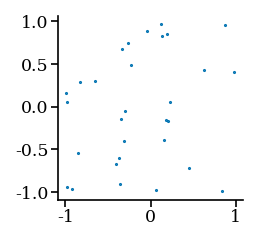

In [12]:
key, subkey = jax.random.split(key)
fs = Geometer(square_arena, flat_metric, key) # flat metric, square arena
plt.plot(*fs.params["centers"][0].T, "o") # plot centers

In [13]:
key, subkey = jax.random.split(key)
fs_loss = fs.train(subkey, train_steps, square_dataset, batch_size, learning_rate)

100%|██████████| 120000/120000 [12:26<00:00, 160.70it/s]


Optimization complete.
Scale After 107.40037


Text(0, 0.5, 'Loss')

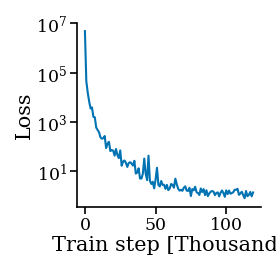

In [14]:
print("Optimization complete.")
print("Scale After", fs.params["scale"])
plt.semilogy(fs_loss)
plt.xlabel("Train step [Thousand]" )
plt.ylabel("Loss")

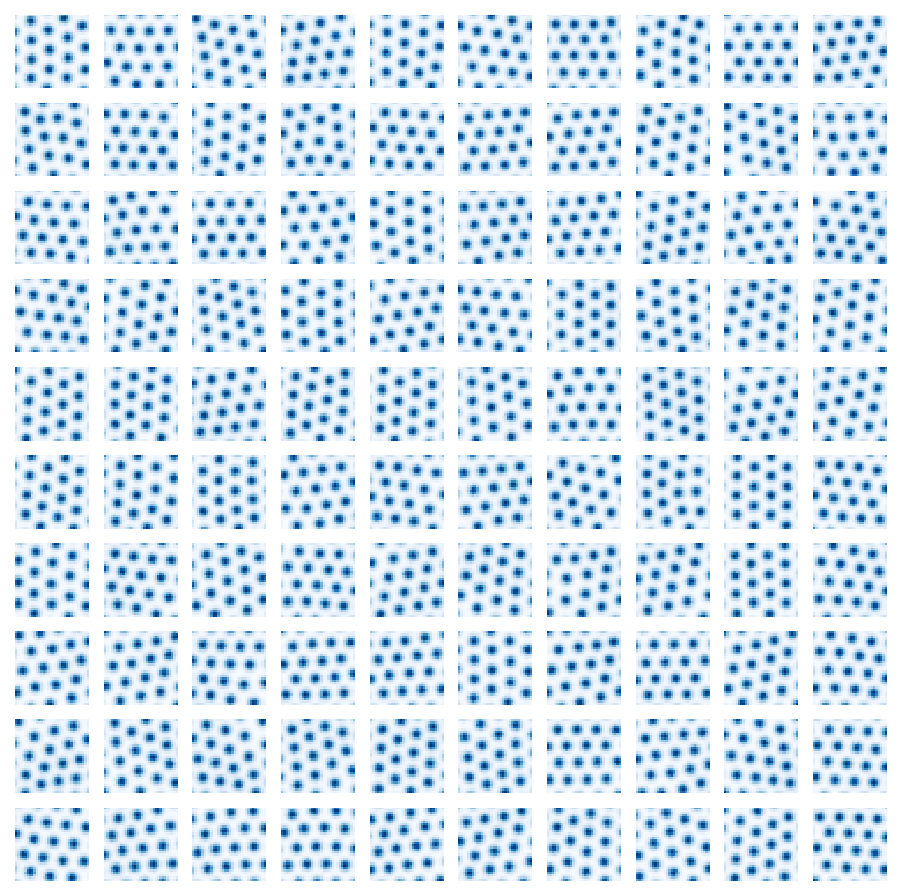

In [63]:
key, subkey = jax.random.split(key)
r = square_arena.sample(100**2, subkey)

square_rates = batch_representation_func(r, fs.params["centers"], fs.sigma*0.5) 
square_ratemaps = scipy.stats.binned_statistic_2d(r[:,0], r[:,1], square_rates.T, bins = [32,32])[0]

fig, ax = plt.subplots(10, 10, figsize = (7.5, 7.5))
ax = ax.ravel()

for i in range(100):
    ax[i].imshow(square_ratemaps[i].T)
    ax[i].axis("off")

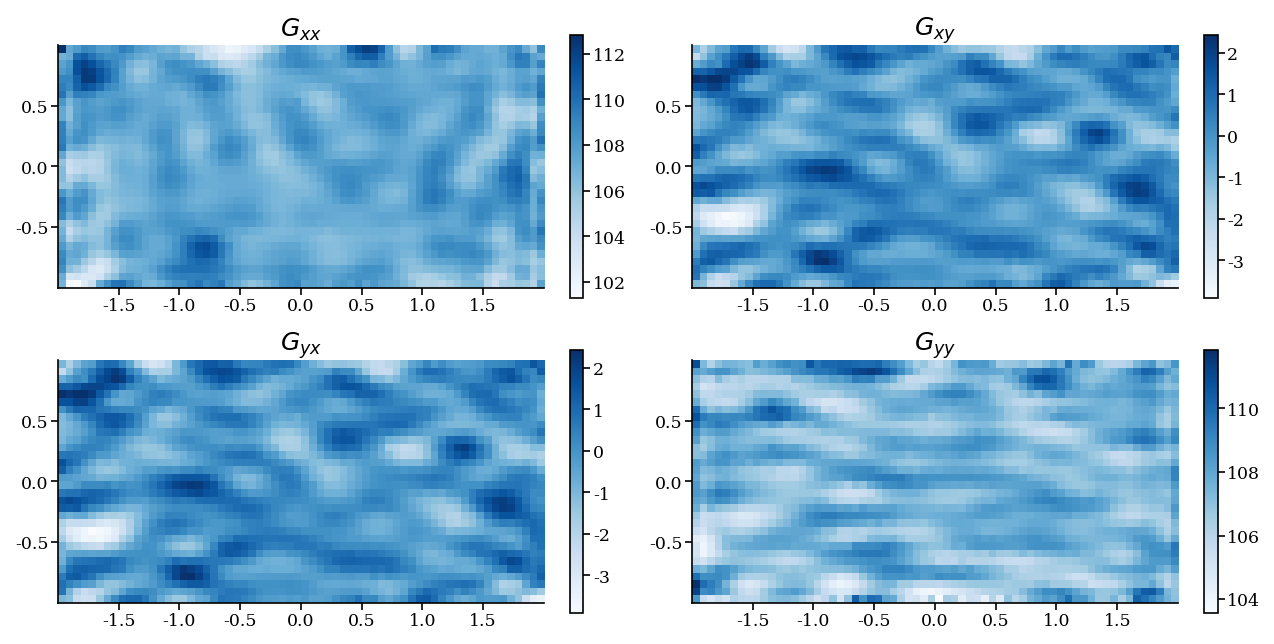

In [58]:
key, subkey = jax.random.split(key)
r = square_arena.sample(20000, subkey)
J = representation_jacobian(r, fs.params["centers"], fs.sigma)
m = J.transpose(0, 2, 1) @ J
fig, ax = plt.subplots(2, 2, figsize = (10, 5))
count = 0
titles = ["$G_{xx}$", "$G_{xy}$", "$G_{yx}$", "$G_{yy}$"]

for i in range(2):
    for j in range(2):
        mij = scipy.stats.binned_statistic_2d(r[:,0], r[:,1], m[:,i,j], bins = [64, 32])[0]
        im = ax[i,j].imshow(mij.T, extent = [np.amin(rr[:,0]), np.amax(rr[:,0]), np.amin(rr[:,1]), np.amax(rr[:,1])])
        ax[i,j].set_title(titles[count])
        count += 1
        plt.colorbar(im, ax = ax[i,j], fraction = 0.03,)
        

(-2.1584903955459596,
 1.9764802217483521,
 -0.9303497076034546,
 0.8311880826950073)

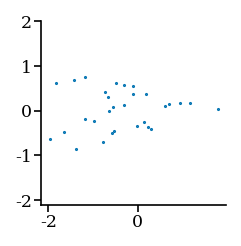

In [16]:
key, subkey = jax.random.split(key)
ft = Geometer(trapezoid_arena, flat_metric, key) # flat metric, trapezoid arena
plt.plot(*ft.params["centers"][0].T, "o")
plt.axis("equal")

In [17]:
key, subkey = jax.random.split(key)
ft_loss = ft.train(subkey, train_steps, trapezoid_dataset, batch_size, learning_rate)

100%|██████████| 120000/120000 [13:35<00:00, 147.18it/s]


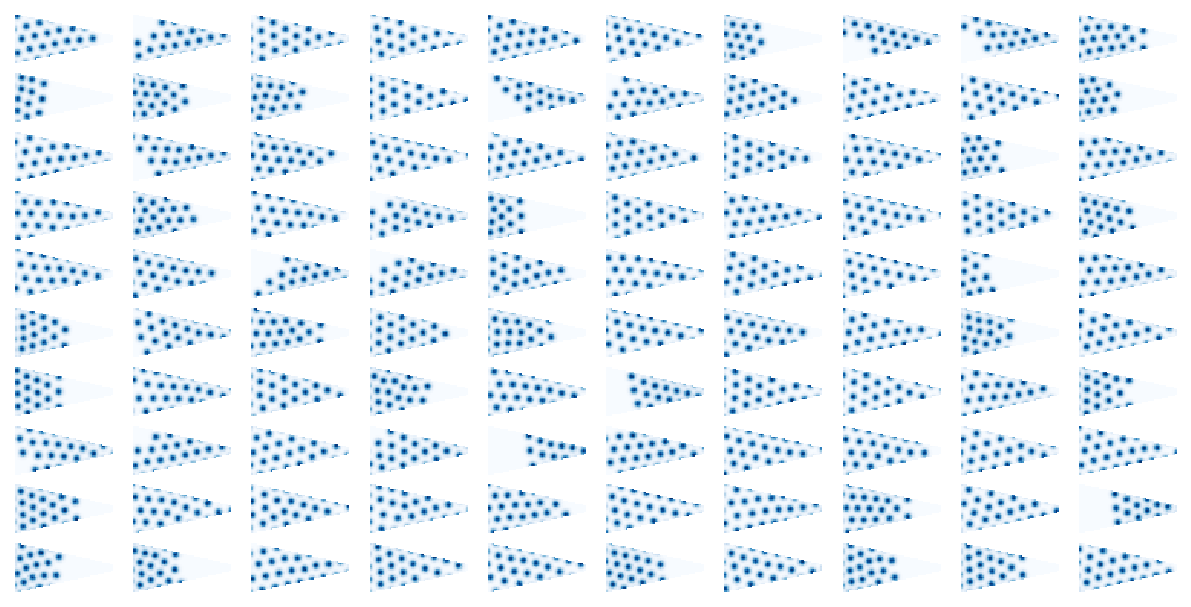

In [96]:
key, subkey = jax.random.split(key)
r = trapezoid_arena.sample(100**2, subkey)

ft_rates = batch_representation_func(r, ft.params["centers"], ft.sigma*0.5) 
ft_ratemaps = scipy.stats.binned_statistic_2d(r[:,0], r[:,1], ft_rates.T, bins = [64, 32])[0]

fig, ax = plt.subplots(10, 10, figsize = (10, 5))
ax = ax.ravel()

for i in range(100):
    ax[i].imshow(ft_ratemaps[i].T)
    ax[i].axis("off")

In [19]:
print(f"Scale after {ft.params['scale']}")

Scale after 145.2921142578125


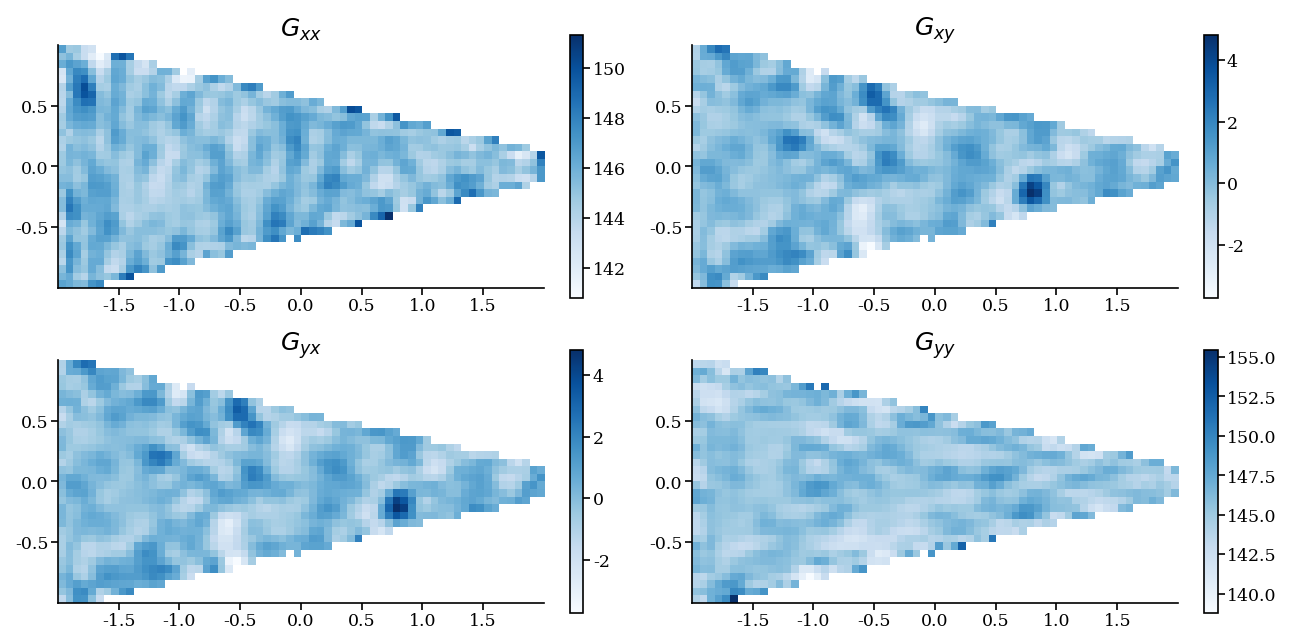

In [55]:
J = representation_jacobian(r, ft.params["centers"], ft.sigma)
m = J.transpose(0, 2, 1) @ J
fig, ax = plt.subplots(2, 2, figsize = (10, 5))
count = 0
titles = ["$G_{xx}$", "$G_{xy}$", "$G_{yx}$", "$G_{yy}$"]

for i in range(2):
    for j in range(2):
        mij = scipy.stats.binned_statistic_2d(r[:,0], r[:,1], m[:,i,j], bins = [64, 32])[0]
        im = ax[i,j].imshow(mij.T, extent = [np.amin(rr[:,0]), np.amax(rr[:,0]), np.amin(rr[:,1]), np.amax(rr[:,1])])
        ax[i,j].set_title(titles[count])
        count += 1
        plt.colorbar(im, ax = ax[i,j], fraction = 0.03,)
        

(-2.1914885520935057,
 2.1110575675964354,
 -0.6667450666427612,
 0.8361095190048218)

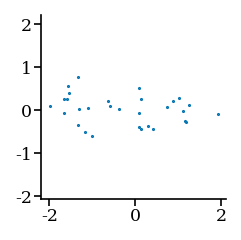

In [21]:
key, subkey = jax.random.split(key)
dt = Geometer(trapezoid_arena, distorted_metric, key) # distorted metric, trapezoid arena
plt.plot(*dt.params["centers"][0].T, "o")
plt.axis("equal")

In [22]:
key, subkey = jax.random.split(key)
dt_loss = dt.train(subkey, train_steps, trapezoid_dataset, batch_size, learning_rate)

100%|██████████| 120000/120000 [13:03<00:00, 153.15it/s]


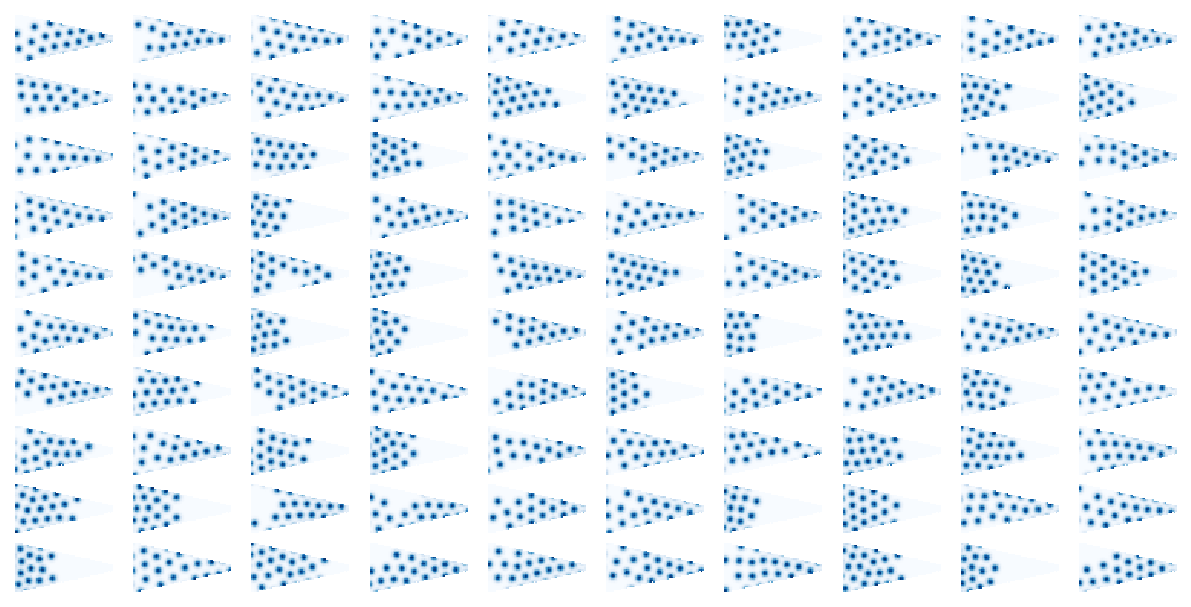

In [97]:
key, subkey = jax.random.split(key)
r = trapezoid_arena.sample(100**2, subkey)

dt_rates = batch_representation_func(r, dt.params["centers"], dt.sigma*0.5) 
dt_ratemaps = scipy.stats.binned_statistic_2d(r[:,0], r[:,1], dt_rates.T, bins = [64, 32])[0]

fig, ax = plt.subplots(10, 10, figsize = (10, 5))
ax = ax.ravel()
for i in range(100):
    ax[i].imshow(dt_ratemaps[i].T)
    ax[i].axis("off")

In [24]:
print(f"Scale after {dt.params['scale']}")

Scale after 62.89445114135742


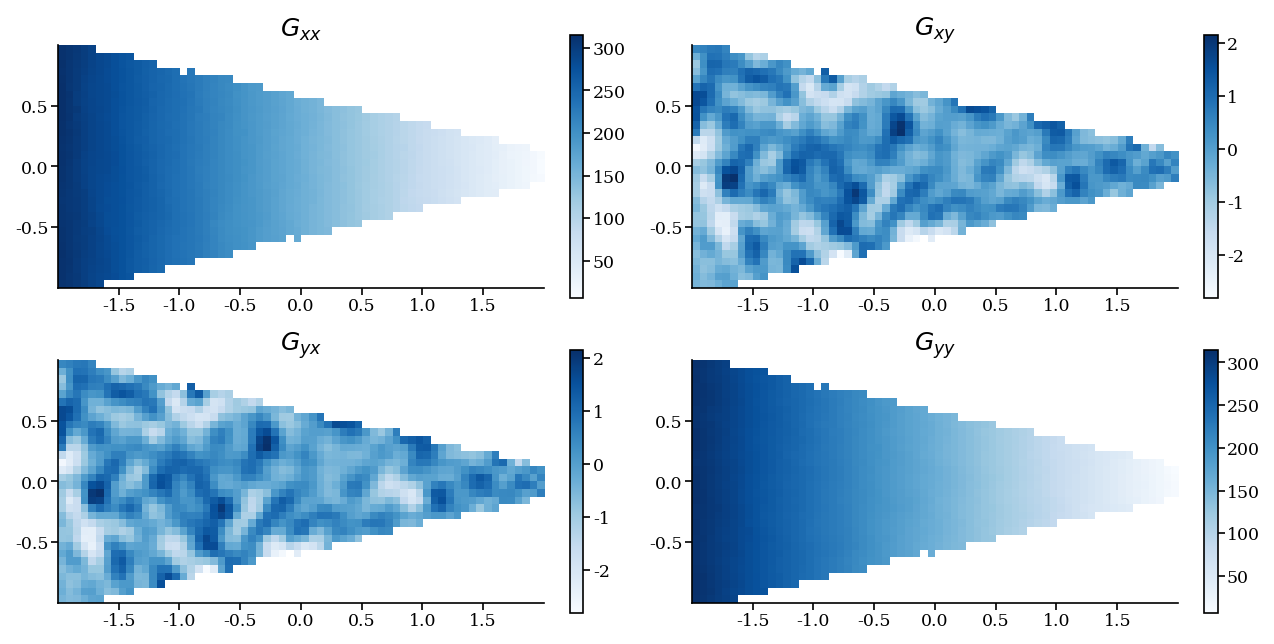

In [25]:
J = representation_jacobian(r, dt.params["centers"], dt.sigma)
m = J.transpose(0, 2, 1) @ J
fig, ax = plt.subplots(2, 2, figsize = (10, 5))
count = 0
titles = ["$G_{xx}$", "$G_{xy}$", "$G_{yx}$", "$G_{yy}$"]

for i in range(2):
    for j in range(2):
        mij = scipy.stats.binned_statistic_2d(r[:,0], r[:,1], m[:,i,j], bins = [64, 32])[0]
        im = ax[i,j].imshow(mij.T, extent = [np.amin(rr[:,0]), np.amax(rr[:,0]), np.amin(rr[:,1]), np.amax(rr[:,1])])
        ax[i,j].set_title(titles[count])
        count += 1
        plt.colorbar(im, ax = ax[i,j], fraction = 0.03,)

In [26]:
import numpy as np
import matplotlib.pyplot as plt


def fit_ellipse(x, y):
    """

    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].

    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.


    """

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()


def cart_to_pol(coeffs):
    """

    Convert the cartesian conic coefficients, (a, b, c, d, e, f), to the
    ellipse parameters, where F(x, y) = ax^2 + bxy + cy^2 + dx + ey + f = 0.
    The returned parameters are x0, y0, ap, bp, e, phi, where (x0, y0) is the
    ellipse centre; (ap, bp) are the semi-major and semi-minor axes,
    respectively; e is the eccentricity; and phi is the rotation of the semi-
    major axis from the x-axis.
    """

    # We use the formulas from https://mathworld.wolfram.com/Ellipse.html
    # which assumes a cartesian form ax^2 + 2bxy + cy^2 + 2dx + 2fy + g = 0.
    # Therefore, rename and scale b, d and f appropriately.
    a = coeffs[0]
    b = coeffs[1] / 2
    c = coeffs[2]
    d = coeffs[3] / 2
    f = coeffs[4] / 2
    g = coeffs[5]

    den = b**2 - a*c
    if den > 0:
        raise ValueError('coeffs do not represent an ellipse: b^2 - 4ac must'
                         ' be negative!')

    # The location of the ellipse centre.
    x0, y0 = (c*d - b*f) / den, (a*f - b*d) / den

    num = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    fac = np.sqrt((a - c)**2 + 4*b**2)
    # The semi-major and semi-minor axis lengths (these are not sorted).
    ap = np.sqrt(num / den / (fac - a - c))
    bp = np.sqrt(num / den / (-fac - a - c))

    # Sort the semi-major and semi-minor axis lengths but keep track of
    # the original relative magnitudes of width and height.
    width_gt_height = True
    if ap < bp:
        width_gt_height = False
        ap, bp = bp, ap

    # The eccentricity.
    r = (bp/ap)**2
    if r > 1:
        r = 1/r
    e = np.sqrt(1 - r)

    # The angle of anticlockwise rotation of the major-axis from x-axis.
    if b == 0:
        phi = 0 if a < c else np.pi/2
    else:
        phi = np.arctan((2.*b) / (a - c)) / 2
        if a > c:
            phi += np.pi/2
    if not width_gt_height:
        # Ensure that phi is the angle to rotate to the semi-major axis.
        phi += np.pi/2
    phi = phi % np.pi

    return x0, y0, ap, bp, e, phi


def get_ellipse_pts(params, npts=100, tmin=0, tmax=2*np.pi):
    """
    Return npts points on the ellipse described by the params = x0, y0, ap,
    bp, e, phi for values of the parametric variable t between tmin and tmax.

    """

    x0, y0, ap, bp, e, phi = params
    # A grid of the parametric variable, t.
    t = np.linspace(tmin, tmax, npts)
    x = x0 + ap * np.cos(t) * np.cos(phi) - bp * np.sin(t) * np.sin(phi)
    y = y0 + ap * np.cos(t) * np.sin(phi) + bp * np.sin(t) * np.cos(phi)
    return x, y


# if __name__ == '__main__':
#     # Test the algorithm with an example elliptical arc.
#     npts = 250
#     tmin, tmax = np.pi/6, 4 * np.pi/3
#     x0, y0 = 4, -3.5
#     ap, bp = 7, 3
#     phi = np.pi / 4
#     # Get some points on the ellipse (no need to specify the eccentricity).
#     x, y = get_ellipse_pts((x0, y0, ap, bp, None, phi), npts, tmin, tmax)
#     noise = 0.1
#     x += noise * np.random.normal(size=npts) 
#     y += noise * np.random.normal(size=npts)

#     coeffs = fit_ellipse(x, y)
#     print('Exact parameters:')
#     print('x0, y0, ap, bp, phi =', x0, y0, ap, bp, phi)
#     print('Fitted parameters:')
#     print('a, b, c, d, e, f =', coeffs)
#     x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
#     print('x0, y0, ap, bp, e, phi = ', x0, y0, ap, bp, e, phi)

#     plt.plot(x, y, 'x')     # given points
#     x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))
#     plt.plot(x, y)
#     plt.show()

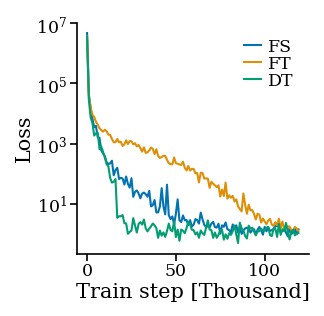

In [117]:
# plot all losses
plt.figure(figsize = (2,2))
for loss, model in zip([fs_loss, ft_loss, dt_loss], ["FS", "FT", "DT"]):
    plt.semilogy(loss, label = model)
plt.xlabel("Train step [Thousand]" )
plt.ylabel("Loss")
plt.legend(frameon = False)

/var/folders/rv/mky69fln76nbwl7qkb06318h0000gn/T/ipykernel_27953/1806713284.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  phi = np.arctan((2.*b) / (a - c)) / 2
/var/folders/rv/mky69fln76nbwl7qkb06318h0000gn/T/ipykernel_27953/945971882.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


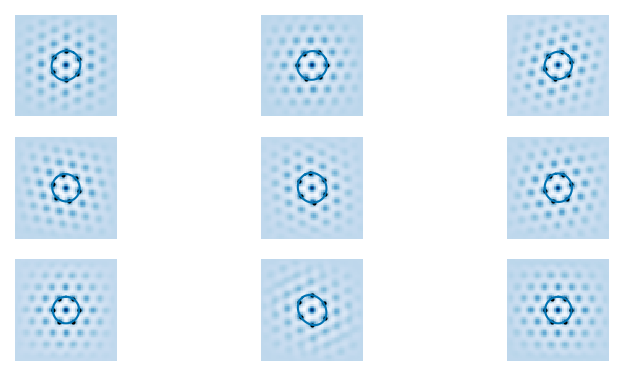

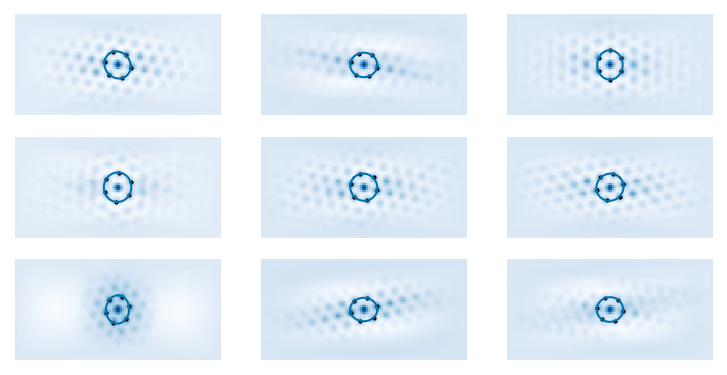

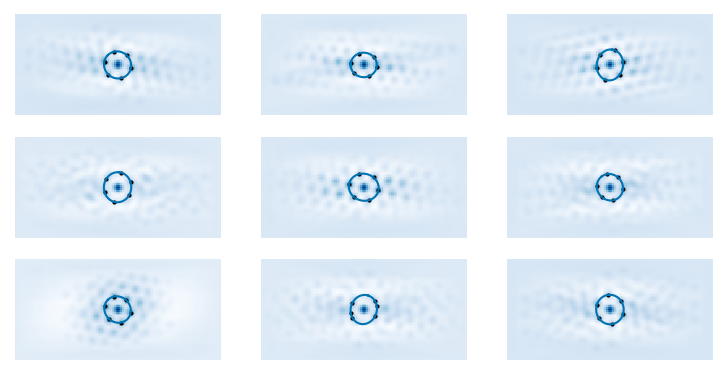

In [98]:
nc = 256
ecc = np.zeros((3, nc))

for num, ratemaps in enumerate([square_ratemaps, ft_ratemaps, dt_ratemaps]):
    # square_smoothed = square_ratemaps#
    # smoothed = np.array([astropy.convolution.convolve(ratemap, astropy.convolution.Gaussian2DKernel(2), boundary = "fill", fill_value=0) for ratemap in ratemaps])
    ratemaps[np.isnan(ratemaps)] = 0.0
    acorrs = np.array([sm.autocorrelation(ratemap, mode = "full", normalize=True) for ratemap in ratemaps])
    peaks = [sm.find_peaks(acorr) for acorr in acorrs]

    shift = np.array(acorrs.shape[1:])//2
    peaks = [peak - shift for peak in peaks]

    for i in range(nc):
        try:
            coeffs = fit_ellipse(peaks[i][1:7][:,0], peaks[i][1:7][:,1])
            x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
            x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))
            ecc[num, i] = e
        except:
            ecc[num,i] = np.nan 

    fig, ax = plt.subplots(3, 3, figsize = (6, 3))
    ax = ax.ravel()

    for i in range(9):
        ax[i].imshow(acorrs[i].T, extent = [-shift[0], shift[0], -shift[1], shift[1]], origin = "lower")
        ax[i].plot(*peaks[i][1:7].T, "ko", markersize = 1)
        coeffs = fit_ellipse(peaks[i][1:7][:,0], peaks[i][1:7][:,1])
        x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
        x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))
        ax[i].plot(x, y)
        ax[i].axis("off")
    fig.show()


Text(0, 0.5, 'Count')

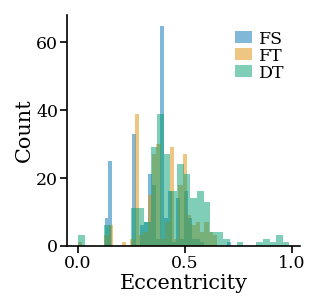

In [116]:
plt.figure(figsize = (2,2))
for i, name in enumerate(["FS", "FT", "DT"]):
    plt.hist(ecc[i], label = name, bins = 32, alpha = 0.5)
plt.legend(frameon = False)
plt.xlabel("Eccentricity")
plt.ylabel("Count")